In [1]:
! nvidia-smi

Tue Nov  8 17:10:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 34%   63C    P2   179W / 350W |  12262MiB / 24576MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   

In [2]:
import os, random

cuda_device = 5
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

In [3]:
# "Basic" py library
import pandas as pd
import numpy as np
from sklearn import metrics

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
from tqdm import tqdm  # generats progress bar to controll steps

import torch # Pytorch, Meta's library for ML
import torch.nn as nn # torch module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [6]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed 
seed = 31
set_seed(seed)

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[Dataset and Model Setup](#setup)

[Training and Evaluation](#train_eval)

[Analysis](#analysis)

## Loading data<a id='intro'></a>

In [7]:
# Load the dataset in CSV
dream_records = pd.read_csv(
    "Reports_DreamerEmotions_PCACho_tsneCho_KMCluster2_KMCluster6_2WSA_6WSA.csv"
)

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}

#### [Multi-Label Classification](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_multi_label_classification.ipynb)<a id='multi'></a>

Convert each set of labels/Emotion is a list signaling the prsence/absence of each emotion.

In [8]:
emotions_list = list(Coding_emotions.keys())
emotions_list.remove("Missing")

report_as_multi_label = []
for rprt_emtn_lst in tqdm(dream_records["Emotions"]):
    lcl_report_as_multi_label = []
    for emotion_acronim in emotions_list:
        if emotion_acronim in rprt_emtn_lst:
            lcl_report_as_multi_label.append(1)
        else:
            lcl_report_as_multi_label.append(0)
    report_as_multi_label.append(lcl_report_as_multi_label)

dream_records["Report_as_Multilabel"] = report_as_multi_label

# final_df_dataset = dream_records

final_df_dataset = dream_records[~dream_records["# Emotions"].isin([0])].reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 1845/1845 [00:00<00:00, 515590.04it/s]


In [9]:
final_df_dataset.columns

Index(['gender', 'age', 'type', 'collection', 'id', 'time', 'date', 'number',
       'report', '# words', 'Emotions', '# Emotions', 'TSNE_x', 'TSNE_y',
       'PCA_x', 'PCA_y', 'Kmean_Cluster_6', 'Kmean Cluster_2', '2W_SA_label',
       '2W_SA_score', '6W_SA_dict', 'Report_as_Multilabel'],
      dtype='object')

In [10]:
final_df_dataset = final_df_dataset[["report", "Report_as_Multilabel"]]

## Dataset and Model Setup<a id='setup'></a>

In [11]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer                      # the Tokenizer model
        self.data      = dataframe                      # the full dataset
        self.report    = dataframe.report               # the text data (i.e., the reports)
        self.targets   = self.data.Report_as_Multilabel # labels' list to classify
        self.max_len   = max_length                     # max length fro truncation

    def __len__(self):
        return len(self.report)

    def __getitem__(self, index):
        report = str(self.report[index])
        report = " ".join(report.split())

        inputs = self.tokenizer.encode_plus(
            report,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [12]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 5
train_batch_size  = 8
valid_batch_size  = 4
train_ratio       = .7
learning_rate     = 1e-05
froze_model_layer = False 

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [13]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset = final_df_dataset.sample(frac=train_size, random_state=seed)
test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset:  {}".format(final_df_dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset:  {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, max_length)
testing_set = CustomDataset(test_dataset, tokenizer, max_length)

FULL Dataset:  (778, 2)
TRAIN Dataset: (622, 2)
TEST Dataset:  (156, 2)


In [14]:
train_params = {
    'batch_size': train_batch_size,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': valid_batch_size,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader  = DataLoader(testing_set, **test_params)

In [15]:
# Creating the customized model, by adding a drop out and a dense layer on top of 
# the BERT (or any other) model, to get the final output. 
class BERTClass(torch.nn.Module):
    def __init__(self, model_name, n_classes, freeze_BERT=False, layer=-1, idx=0):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained(model_name)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, n_classes)
        self.layer = layer
        self.idx   = idx  
        # Froze the weight of model aside of the classifier
        if froze_model_layer:
            print("Freezing the layer of BERT model")
            for name, param in self.l1.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False
                    
    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = output_1.last_hidden_state[:, -1, :]
        output_2 = self.l2(output_1)
        output   = self.l3(output_2)
        return output

# Loss function 
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Training regime
def train(epoch, model, optimizer):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Validate (test) the model
def validation(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [16]:
model_tuned = BERTClass(
    model_name=model_name, 
    n_classes=len(emotions_list), 
    freeze_BERT=False
)

model_tuned.to(device)

optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training and Evaluation<a id='train_eval'></a>

In [17]:
for ep in range(epochs):
    train(ep, model_tuned, optimizer_tuned)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  0.70921391248703
Epoch: 1, Loss:  0.5767597556114197
Epoch: 2, Loss:  0.5465983748435974
Epoch: 3, Loss:  0.4626264274120331
Epoch: 4, Loss:  0.3593732416629791


In [18]:
outputs, targets = validation(model_tuned)
outputs = np.array(outputs) >= 0.5

In [19]:
print(
    metrics.classification_report(
    targets,
    outputs,
    target_names=emotions_list,
    zero_division=0,
    )
)

              precision    recall  f1-score   support

          AN       0.85      0.85      0.85        27
          AP       0.89      0.81      0.85        68
          SD       0.86      0.27      0.41        22
          CO       0.84      0.52      0.64        31
          HA       0.92      0.72      0.81        32

   micro avg       0.88      0.68      0.77       180
   macro avg       0.87      0.63      0.71       180
weighted avg       0.88      0.68      0.75       180
 samples avg       0.75      0.72      0.72       180



## Analysis<a id='analysis'></a>

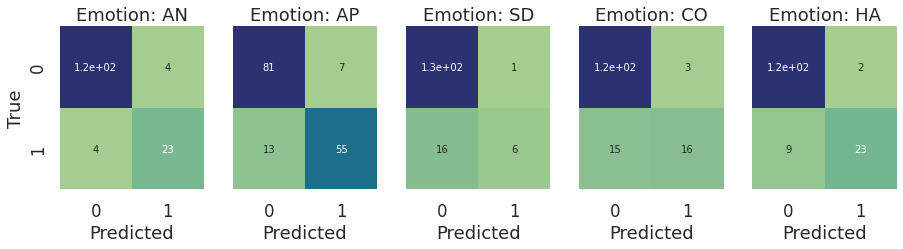

In [26]:
emotions_CM = metrics.multilabel_confusion_matrix(
    targets,
    outputs,
)

plt.figure(figsize=(15, 3))
for cnt, cm in enumerate(emotions_CM): 
    
    plt.subplot(1,5,cnt+1) 
    g = sns.heatmap(cm, cmap="crest", cbar=False, annot=True)
    plt.title("Emotion: {}".format(emotions_list[cnt]))
    plt.xlabel("Predicted")
    if cnt == 0:
        plt.ylabel("True")
    else:
        g.set_yticklabels(["", ""])
        
# plt.tight_layout()
plt.show()

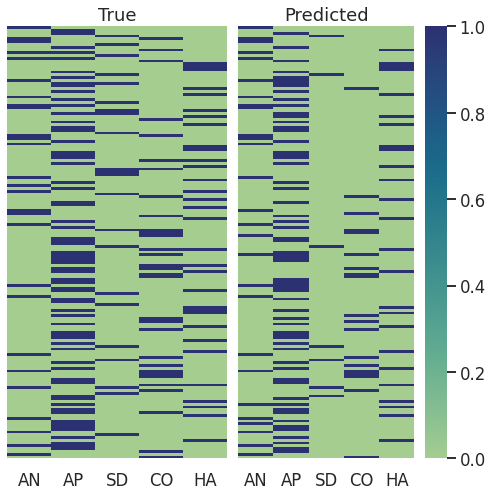

In [24]:
plt.figure(figsize=(7, 7))
for cnt, [name, data] in enumerate({"True":targets, "Predicted":outputs}.items()): 
    
    _bar = True if cnt != 0 else False
    plt.subplot(1,2,cnt+1) 
    g = sns.heatmap(
        data, 
        cmap="crest", 
        yticklabels=False, 
        xticklabels=emotions_list,
        cbar=_bar,
    )
    plt.title("{}".format(name))
        
plt.tight_layout()
plt.show()